In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/git_workspace/16715/dynamics-simulation-leg/scripts/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using MeshCatMechanisms
using MeshCat
using StaticArrays
using SparseArrays
using ForwardDiff

WebIO._IJuliaInit()

In [3]:
# link lengths
const l0 = 0.1
const l1 = 0.3
const l2 = 0.3
const l3 = 0.1
const l4 = 0.2
const l5 = 0.0205
const lee = [l3 + l4; l5; 0] # sqrt((l3 + l4)^2 + l5^2)

# CoM locations
const l_cb = [0; 0.004; 0]
const l_c0 = [0.0125108364230515; 0.00117191218927888; 0]
const l_c1 = [0.149359714867044; 0; 0]
const l_c2 = [0.0469412900551914; 0; 0]
const l_c3 = [0.113177000131857; -0.015332867880069; 0]

# link masses
const mb = 7  # kg
const m0 = 0.24644240965487
const m1 = 0.0707939028219395
const m2 = 0.276735496985514
const m3 = 0.130824780046739
const m = diagm([m0, m1, m2, m3])
    
# gravity, obviously
const g = 9.807

# mass moment of inertia in axis of rotation
const Ib = Array([0.0024241 5.252E-06 2.0733E-19; 
                  5.252E-06 0.0044176 -3.1153E-19; 
                  2.0733E-19 -3.1153E-19 0.0022481])

const I0 = Array([3.83120149546952E-05 1.46925714738609E-05 -8.60106401672571E-06;
                  1.46925714738609E-05 0.000172067745507247 1.0427260925207E-06;
                  -8.60106401672571E-06 1.0427260925207E-06 0.00014745218068435])

const I1 = Array([3.06999775886187E-06 7.91090301514898E-12 -1.43705963146176E-12;
                  7.91090301514898E-12 0.000147960574744097 1.30742394049546E-11;
                  -1.43705963146176E-12 1.30742394049546E-11 0.000147884231885009])

const I2 = Array([3.43038397803592E-05 -2.90339844227483E-07 6.18680397558952E-06;
                  -2.90339844227483E-07 0.000302324068012293 2.25016327583562E-08;
                  6.18680397558952E-06 2.25016327583562E-08 0.00028292376778719])

const I3 = Array([1.76996970020568E-05 -5.3695427116208E-07 7.62350214406387E-07;
                  -5.3695427116208E-07 0.000164188445564489 -2.77843753828047E-07;
                  7.62350214406387E-07 -2.77843753828047E-07 0.000160656046697151])
# const J = Diagonal([I0, I1, I2, I3])

3×3 Matrix{Float64}:
  1.76997e-5  -5.36954e-7    7.6235e-7
 -5.36954e-7   0.000164188  -2.77844e-7
  7.6235e-7   -2.77844e-7    0.000160656

In [4]:
M̄ = [mb*I(3) zeros(3, 27)
     zeros(3,3) Ib zeros(3, 24)
     zeros(3,6) m0*I(3) zeros(3,21);
     zeros(3,9) I0 zeros(3,18);
     zeros(3,12) m1*I(3) zeros(3,15);
     zeros(3,15) I1 zeros(3, 12);
     zeros(3,18) m2*I(3) zeros(3, 9);
     zeros(3, 21) I2 zeros(3, 6);
     zeros(3, 24) m3*I(3) zeros(3, 3);
     zeros(3, 27) I3]

30×30 SparseMatrixCSC{Float64, Int64} with 60 stored entries:
⠑⢄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠘⠛⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⢱⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⣀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠘⠛⢄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢱⣶⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⣀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛

In [5]:
function hat(ω)
    return [0 -ω[3] ω[2];
            ω[3] 0 -ω[1];
            -ω[2] ω[1] 0]
end

function L(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I + hat(Q[2:4])]
end

function R(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I - hat(Q[2:4])]
end

H = [zeros(1,3); I];

T = Diagonal([1.0; -1; -1; -1])

function G(Q)
    return L(Q)*H  # 4x3
end

function Ḡ(q)
    Q = q[4:7]
    return [I(3) zeros(3,4); zeros(4,3) G(Q) zeros(4,1); zeros(1,6) 1]
end

function G̃(q)
    Q = q[4:7]
    #return [I(3) zeros(3,7); zeros(4,3) 0.5*G(Q) zeros(4,4); zeros(1,6) 1 zeros(1, 3)]  # 8x10
    #11x10
   return blockdiag(sparse(I, 3, 3), sparse(0.5*G(Qb)),sparse(I, 4, 4))
end

G̃ (generic function with 1 method)

In [6]:
function Expq(ϕ)
    # The quaternion exponential map ϕ → Q 
    # Convert axis angle to quaternion
    Q = zeros(eltype(ϕ), 4)
    θ = norm(ϕ)
    r = ϕ/θ
    Q[1] = cos(θ/2)
    Q[2:4] = r*sin.(θ/2)
    return Q
end

function rotate(Q, p)
    # Rotate a position vector p by a quaternion Q
    return H'L(Q)*R(Q)'*H*p
end

rotate (generic function with 1 method)

In [7]:
#Kinematics
function kinematics(q)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    pb = rb + rotate(Qb, l_cb)  # position vector from world frame to *JOINTS* 0 and 2
    
    Qb0 = Expq([0, q0, 0])  # quaternion from base to link 0
    Q0 = L(Qb)*Qb0  # quaternion from world frame to link 0
    r0 = pb + rotate(Q0, l_c0)
    
    Q01 = Expq([0, q1, 0])  # quaternion from link 0 to link 1
    Q1 = L(Q0)*Q01  # quaternion from world frame to link 1
    r1 = pb + rotate(Q0, [l0; 0; 0]) + rotate(Q1, l_c1)  
    
    Qb2 = Expq([0, q2, 0])  # quaternion from base to link 2
    Q2 = L(Qb)*Qb2  # quaternion from world frame to link 2
    r2 = pb + rotate(Q2, l_c2)
    
    Q23 = Expq([0, q3, 0])  # quaternion from base to link 2
    Q3 = L(Q2)*Q23  # quaternion from world frame to link 2
    r3 = pb + rotate(Q2, [l2; 0; 0]) + rotate(Q3, l_c3)  
    
    return [rb; Qb; r0; Q0; r1; Q1; r2; Q2; r3; Q3]
end

kinematics (generic function with 1 method)

In [8]:

#Kinematic Jacobian
function K(q)
    k = kinematics(q);
    rb = k[1:3]
    Qb = k[4:7]
    r0 = k[8:10]
    Q0 = k[11:14]
    r1 = k[15:17]
    Q1 = k[18:21]
    r2 = k[22:24]
    Q2 = k[25:28]
    r3 = k[29:31]
    Q3 = k[32:35]
    
    dk = ForwardDiff.jacobian(dq->kinematics(dq),q)  # 35x11

    # 30x35
    Ḡ1 = blockdiag(sparse(I, 3, 3), sparse(2*G(Qb)'),
                   sparse(I, 3, 3), sparse(2*G(Q0)'),
                   sparse(I, 3, 3), sparse(2*G(Q1)'),
                   sparse(I, 3, 3), sparse(2*G(Q2)'),
                   sparse(I, 3, 3), sparse(2*G(Q3)'),)

    # 11x10
    Ḡ2 = blockdiag(sparse(I, 3, 3), sparse(0.5*G(Qb)),
                   sparse(I, 4, 4))
    
    K = Ḡ1*dk*Ḡ2
        
    return K
end

K (generic function with 1 method)

In [9]:
#Mass Matrix
function M(q)    
    return K(q)'*M̄*K(q)
end

# eigvals(M(q0))

M (generic function with 1 method)

In [10]:
#Potential
function U(q)
    return 0.0  # assume zero gravity for now
end

function DQ0U(q)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(dQb->U([rb; dQb; q0; q1; q2; q3]), Qb)
end



DQ0U (generic function with 1 method)

In [11]:
#Lagrangian
function Lagrangian(q,v)
    0.5*v'*M(q)*v - U(q)
end

Lagrangian (generic function with 1 method)

In [12]:
#Initial Conditions
rb = zeros(3)
Qb = [1.0; 0; 0; 0]
q0 = -30*pi/180;
q1 = -120*(pi/180)
q2 = -150*(pi/180)
q3 = 120*(pi/180)
q_init = [rb; Qb; q0; q1; q2; q3]

q̇0 = 0.0
q̇1 = 0.0
q̇2 = 0.0
q̇3 = 0.0
ωb = zeros(3)
ṙb = zeros(3) #cross(ω0,[-0.5*ℓ1; 0; 0])
v_init = [ṙb; ωb; q̇0; q̇1; q̇2; q̇3]

x_init = [q_init; v_init]

Tf = 10.0
h = 0.001 #20 Hz
thist = 0:h:Tf
N = length(thist)

xhist = zeros(21,N)


#Torque input at joint
uhist = ones(10, N)*1e-4

10×10001 Matrix{Float64}:
 0.0001  0.0001  0.0001  0.0001  0.0001  …  0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001  …  0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001

In [13]:
#Lagrangian Derivatives

function DrbL(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(drb->Lagrangian([drb; Qb; q0; q1; q2; q3],v), rb)
end

function DQbL(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(dQb->Lagrangian([rb; dQb; q0; q1; q2; q3],v), Qb)
end

function Dq0L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq0->Lagrangian([rb; Qb; dq0; q1; q2; q3],v), q0)
end

function Dq1L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq1->Lagrangian([rb; Qb; q0; dq1; q2; q3],v), q1)
end

function Dq2L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq2->Lagrangian([rb; Qb; q0; q1; dq2; q3],v), q2)
end

function Dq3L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq3->Lagrangian([rb; Qb; q0; q1; q2; dq3],v), q3)
end

function DṙbL(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.gradient(dṙb->Lagrangian(q,[dṙb; ωb; q̇0; q̇1; q̇2; q̇3]), ṙb)
end
    
function DωbL(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.gradient(dωb->Lagrangian(q,[ṙb; dωb; q̇0; q̇1; q̇2; q̇3]), ωb)
end

function Dq̇0L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇0->Lagrangian(q,[ṙb; ωb; dq̇0; q̇1; q̇2; q̇3]), q̇0)
end

function Dq̇1L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇1->Lagrangian(q,[ṙb; ωb; q̇0; dq̇1; q̇2; q̇3]), q̇1)
end

function Dq̇2L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇2->Lagrangian(q,[ṙb; ωb; q̇0; q̇1; dq̇2; q̇3]), q̇2)
end

function Dq̇3L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇3->Lagrangian(q,[ṙb; ωb; q̇0; q̇1; q̇2; dq̇3]), q̇3)
end

Dq̇3L (generic function with 1 method)

In [14]:
#Input Jacobian
function B(q)
    #[zeros(7); 1.0; zeros(2)]
    ones(10)
end

B (generic function with 1 method)

In [15]:
#EL Dynamics
function f(x,u)
    q = x[1:11]
    v = x[12:21]  # 10
    ω = v[4:6]

    q̇ = G̃(q)*v
    
    Mq = [ForwardDiff.jacobian(dv->DṙbL(q,dv),v);  # 10x10
          ForwardDiff.jacobian(dv->DωbL(q,dv),v);
          ForwardDiff.gradient(dv->Dq̇0L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇1L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇2L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇3L(q,dv),v)']

    CG = [-ForwardDiff.jacobian(dq->DṙbL(dq,v),q)*G̃(q)*v + DrbL(q,v);  # 10
          -ForwardDiff.jacobian(dq->DωbL(dq,v),q)*G̃(q)*v - hat(ω)*DωbL(q,v) .+ 0.5*G(Qb)'*DQ0U(q);
          -ForwardDiff.gradient(dq->Dq̇0L(dq,v),q)'*G̃(q)*v + Dq0L(q,v);
          -ForwardDiff.gradient(dq->Dq̇1L(dq,v),q)'*G̃(q)*v + Dq1L(q,v);
          -ForwardDiff.gradient(dq->Dq̇2L(dq,v),q)'*G̃(q)*v + Dq2L(q,v);
          -ForwardDiff.gradient(dq->Dq̇3L(dq,v),q)'*G̃(q)*v + Dq3L(q,v)]

    v̇ = Mq\(CG + B(q)*u)
    
    #ForwardDiff.jacobian(dv->Dṙ0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dṙ0L(dq,v),q)*G̃(q)*v - Dr0L(q,v)
    #ForwardDiff.jacobian(dv->Dω0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dω0L(dq,v),q)*G̃(q)*v + hat(ω)*Dω0L(q,v) - 0.5*H'*L(Q0)'*DQ0L(q,v)
    #ForwardDiff.jacobian(dv->Dq̇1L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dq̇1L(dq,v),q)*G̃(q)*v - Dq1L(q,v)
    
    
    return [q̇; v̇]
end

f (generic function with 1 method)

In [16]:
function rk4_step(f, xk, uk, uk1, h)

    f1 = f(xk, uk)
    f2 = f(xk + 0.5*h*f1, 0.5*(uk + uk1))
    f3 = f(xk + 0.5*h*f2, 0.5*(uk + uk1))
    f4 = f(xk + h*f3, uk1)
    
    xn = xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] = xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    
    return xn
end

rk4_step (generic function with 1 method)

In [17]:
function simulate!(xhist, N)
    print("\r Initializing...")
    flush(stdout)
    for k = 1:(N-1)
        xhist[:,k+1] .= rk4_step(f, xhist[:,k], uhist[k], uhist[k+1], h)
        print("\r Simulation ", trunc(Int, k/(N-1)*100), "% complete")
        flush(stdout)
    end
end

simulate! (generic function with 1 method)

In [18]:
simulate!(xhist, N)

 Simulation 100% complete

In [19]:
q0 = -xhist[8, :] .- 30*(pi/180)
q1 = -xhist[9, :] .- 120*(pi/180)
q2 = -xhist[10, :] .- 150*(pi/180)
q3 = -xhist[11, :] .+ 120*(pi/180)

qs = convert(AbstractArray{Float64}, [q0 q2 q1 q3]) 
ts = convert(AbstractVector{Float64}, thist) # AbstractVector(thist)
q_array = [ qs[i,:] for i in 1:size(qs,1)] 

10001-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [-3.256074621038607e-8, -1.7499488524919116e-8, -1.4440097118040285e-8, -2.844527635659233e-8]
 [-1.3024297784713923e-7, -6.999795676421172e-8, -5.776039380123166e-8, -1.1378110675863695e-7]
 [-2.930466737049997e-7, -1.5749541226739439e-7, -1.299609069249641e-7, -2.560074929824907e-7]
 [-5.209717987009199e-7, -2.799918683571434e-7, -2.310416640227686e-7, -4.5512443858086726e-7]
 [-8.140183037630422e-7, -4.3748734279702717e-7, -3.6100270417449565e-7, -7.111319484387479e-7]
 [-1.1721861254976318e-6, -6.29981859567863e-7, -5.198440780063152e-7, -1.0240300287733817e-6]
 [-1.5954751866331662e-6, -8.574754470913604e-7, -7.075658463584489e-7, -1.3938186880224634e-6]
 [-2.083885395909313e-6, -1.1199681391182992e-6, -9.24168081617438e-7, -1.8204979346236883e-6]
 [-2.6374166478548844e-6, -1.41745997472853e-6, -1.169650867272054e-6, -2.3040677796792863e-6]
 [-3.2560688230098833e-6, -1.7499509983309736e-6, -1.4440142979132986e-6, -2.844

In [20]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations#, GeometryTypes
#const gt = GeometryTypes

In [21]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/ben/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [79]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
red_material = MeshPhongMaterial(color=RGBA(1, 0, 0, 0.8))

l_345 = sqrt((l3 + l4)^2 + l5^2)
# sphere = Sphere(Point(0, 0, 0), 3)
# rect = Rectangle(0.2, 0.2, 0.2, 0.2)
cylinderb = Cylinder(Point(0, -0.05, l_cb[2]), Point(0, 0.05, l_cb[2]), 0.14)  #float(l_cb)
cylinder0 = Cylinder(Point(-l_c0[1], 0, 0), Point(l0-l_c0[1], 0, 0), 0.016)
cylinder1 = Cylinder(Point(-l_c1[1], 0, 0), Point(l1-l_c1[1], 0, 0), 0.016)
cylinder2 = Cylinder(Point(-l_c2[1], 0, 0), Point(l2-l_c2[1], 0, 0), 0.016)
cylinder3 = Cylinder(Point(-l_c3[1], 0, 0), Point(l_345-l_c3[1], 0, 0), 0.016)

# setobject!(vis["sphere"],sphere,red_material)
setobject!(vis["cylinderb"],cylinderb,red_material)
setobject!(vis["cylinder0"],cylinder0,green_material)
setobject!(vis["cylinder1"],cylinder1,green_material)
setobject!(vis["cylinder2"],cylinder2,green_material)
setobject!(vis["cylinder3"],cylinder3,green_material)

for k = 1:N
    
    Xk = kinematics(xhist[:,k])
    # set position and attitude
    positionb = Translation(Xk[1:3]...)
    attitudeb = LinearMap(UnitQuaternion(Xk[4:7]))
    position0 = Translation(Xk[8:10]...)
    attitude0 = LinearMap(UnitQuaternion(Xk[11:14]))
    position1 = Translation(Xk[15:17]...)
    attitude1 = LinearMap(UnitQuaternion(Xk[18:21]))
    position2 = Translation(Xk[22:24]...)
    attitude2 = LinearMap(UnitQuaternion(Xk[25:28]))
    position3 = Translation(Xk[29:31]...)
    attitude3 = LinearMap(UnitQuaternion(Xk[32:35]))
    
    settransform!(vis["cylinderb"], compose(positionb,attitudeb))
    settransform!(vis["cylinder0"], compose(position0,attitude0))
    settransform!(vis["cylinder1"], compose(position1,attitude1))
    settransform!(vis["cylinder2"], compose(position2,attitude2))
    settransform!(vis["cylinder3"], compose(position3,attitude3))
    sleep(0.001)
end

In [23]:
#Energy Functions

function Energy(x)
    q = x[1:11]
    v = x[12:end]
    energy = Lagrangian(q,v)
    return energy
end

Energy (generic function with 1 method)

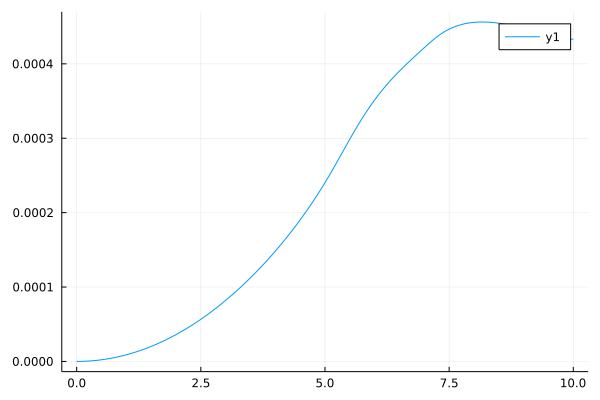

In [24]:
#Plot total energy
using Plots

E = zeros(N)
for k = 1:N
    E[k] = Energy(xhist[:, k])
end

plot(thist,E)

In [25]:
# world = RigidBody{Float64}("world")
# doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

# only works with Rotations v1.0.4 and earlier
# use Pkg.add(Pkg.PackageSpec(;name="Rotations", version="1.0.4"))
curdir = pwd()
urdfpath = joinpath(curdir, "../res/flyhopper_robot/urdf/flyhopper_robot.urdf")
leg = parse_urdf(urdfpath, floating=true)
state = MechanismState(leg)

MechanismState{Float64, Float64, Float64, …}(…)

In [26]:
# mvis = MechanismVisualizer(doublependulum, Skeleton(randomize_colors=true, inertias=false));
mvis = MechanismVisualizer(leg, URDFVisuals(urdfpath));

render(mvis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/ben/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Link 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x32, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "after_Joint 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Link 0" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x30], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x30, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing

In [125]:
q_0 = x_init[8]
q_1 = x_init[9]
q_2 = x_init[10]
q_3 = x_init[11]
#floatingjoint = findjoint(leg, "control")
#set_configuration!(state, floatingjoint, [100; 100; 100; 1; 1; 1; 1.025])
# set_configuration!(mvis, zeros(11))
set_configuration!(mvis, [1,0,0,0,0,0,0, -q_0-30*(pi/180), -q_2-150*(pi/180), -q_1-120*(pi/180), -q_3+120*(pi/180)])

In [104]:
function quat_to_ax(Q)
    # convert quaternion back to axis angles for meshcat animate...
    θ = acos(Q[1]) * 2
    if θ == 0
        xyz = zeros(3)
    else
        xyz = Q[2:4] ./ sin(θ/2)
    end
    return xyz
end

function qinv(Q)
    # quaternion inverse
    Q/(Q'*Q)
end

qinv (generic function with 1 method)

In [131]:
# MeshCatMechanisms.animate(mvis, ts, [1,0,0,0,0,0,0,-q_array], realtimerate = 1.);

for k = 1:N
    
    Xk = kinematics(xhist[:,k])
    
    pb = Xk[1:3]
    Qb = Xk[4:7]
    Q0 = Xk[11:14]
    Q1 = Xk[18:21]
    Q2 = Xk[25:28]
    Q3 = Xk[32:35]

    Qb0 = L(qinv(Qb))*Q0
    Q01 = L(qinv(Q0))*Q1
    Q12 = L(qinv(Q1))*Q2
    Q23 = L(qinv(Q2))*Q3

    a0 = -quat_to_ax(Qb0)[3] #-30*(pi/180)
    a1 = -quat_to_ax(Q01)[3] #-120*(pi/180)
    a2 = -quat_to_ax(Q12)[3] #-150*(pi/180)
    a3 = -quat_to_ax(Q23)[3] #+120*(pi/180)
    #-0.5235987755982988, -2.6179938779914944, -2.0943951023931953, 2.0943951023931953
    
    @show q_array = vcat(Qb, pb, [a0, a2, a1, a3])
    
    set_configuration!(mvis, q_array)

    
end
#=
for k = 1:N
    
    Xk = kinematics(xhist[:,k])
    # set position and attitude
    positionb = Translation(Xk[1:3]...)
    attitudeb = LinearMap(UnitQuaternion(Xk[4:7]))
    position0 = Translation(Xk[8:10]...)
    attitude0 = LinearMap(UnitQuaternion(Xk[11:14]))
    position1 = Translation(Xk[15:17]...)
    attitude1 = LinearMap(UnitQuaternion(Xk[18:21]))
    position2 = Translation(Xk[22:24]...)
    attitude2 = LinearMap(UnitQuaternion(Xk[25:28]))
    position3 = Translation(Xk[29:31]...)
    attitude3 = LinearMap(UnitQuaternion(Xk[32:35]))
    set_configuration!(mvis, [1,0,0,0,0,0,0, -q_0-30*(pi/180), -q_2-150*(pi/180), -q_1-120*(pi/180), -q_3+120*(pi/180)])
    settransform!(vis["cylinderb"], compose(positionb,attitudeb))
    settransform!(vis["cylinder0"], compose(position0,attitude0))
    settransform!(vis["cylinder1"], compose(position1,attitude1))
    settransform!(vis["cylinder2"], compose(position2,attitude2))
    settransform!(vis["cylinder3"], compose(position3,attitude3))
    sleep(0.001)
end
=#

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [1.0, 1.0922227069732939e-9, -5.660479989957095e-9, 2.7002688643039826e-9, -8.516462644128389e-11, 4.1795999262401146e-11, 9.331364901609538e-12, -1.7970636330673436e-8, 3.6868783043075135e-10, 6.879807563610198e-10, -1.203804370742926e-9]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999999999998, 4.368890940387773e-9, -2.2641919947192372e-8, 1.0801075963837337e-8, -3.4065850849386357e-10, 1.6718399512916557e-10, 3.7325458751032237e-11, -7.188255551832712e-8, 1.4747511184040558e-9, 2.7519214305787213e-9, -4.8152181380328436e-9]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999999999984, 9.830005055755448e-9, -5.094431985666975e-8, 2.4302422802367388e-8, -7.664816543118193e-10, 3.7616398190311793e-10, 8.398227893425153e-11, -1.617357879936514e-7, 3.318189276303727e-9, 6.1918172797458844e-9, -1.0834243256589855e-8]
q_array = vcat(Qb, p

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999999969593, 1.3379879894005438e-6, -6.934087824169356e-6, 3.30789166476458e-6, -1.043270063616157e-7, 5.1199863099975174e-8, 1.1430812154431358e-8, -2.2015293755985203e-5, 4.516185679557911e-7, 8.425797272994793e-7, -1.4747415584793554e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999999659661, 1.4155376129029252e-6, -7.3359818847075915e-6, 3.4996181884078593e-6, -1.1037373528672367e-7, 5.416735088838096e-8, 1.209332595208422e-8, -2.329135978865238e-5, 4.777925377580546e-7, 8.914028906827371e-7, -1.560221358505559e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999999620242, 1.4952718393115903e-6, -7.74919690363762e-6, 3.696745895946344e-6, -1.1659079698047463e-7, 5.7218428227706485e-8, 1.2774501339773807e-8, -2.4603380205773167e-5, 5.047036341066615e-7, 9.41599975571787e-7, -1.648109609520322e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999999577491, 1.5771906775007492e-6, -8.173732880870682e-6, 3.89927482377585

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999994850746, 5.5061519716764365e-6, -2.8534477007224852e-5, 1.3613110972933211e-5, -4.2932062555638495e-7, 2.106896334845621e-7, 4.703754830608455e-8, -9.061139742573391e-5, 1.858148305576346e-6, 3.4647782552359773e-6, -6.069753837209263e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999994554456, 5.662354629468582e-6, -2.934392549574894e-5, 1.3999310165791418e-5, -4.4149949766373296e-7, 2.1666623125520338e-7, 4.8371826306992304e-8, -9.31824309592464e-5, 1.9108472380591026e-6, 3.562967720429924e-6, -6.241977048447693e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999994245559, 5.820742363121573e-6, -3.0164694937849607e-5, 1.439091248099615e-5, -4.538487130881202e-7, 2.2272641123154012e-7, 4.9724762475664064e-8, -9.578945820390054e-5, 1.964282548996946e-6, 3.6625249868224282e-6, -6.416611238079982e-6]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999993923703, 5.9813151902861795e-6, -3.099678533334382e-5, 1.47879179908

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999997343787, 1.2506185880064767e-5, -6.480682187257269e-5, 3.0920823903440686e-5, -9.750794400924292e-7, 4.785017633376089e-7, 1.0682518593849215e-7, -0.00020585630300605536, 4.219006112664559e-6, 7.859498424531466e-6, -1.3789455684723805e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999972430851, 1.2741064135943977e-5, -6.60238245540339e-5, 3.1501588165019024e-5, -9.933909582450791e-7, 4.874871208475765e-7, 1.088310648831842e-7, -0.00020972417823077836, 4.298194311080749e-6, 8.006762437820557e-6, -1.404854281240811e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999971395463, 1.2978128257353651e-5, -6.72521481806491e-5, 3.208775877969545e-5, -1.0118728372994694e-6, 4.96556048312528e-7, 1.1085559628241998e-7, -0.00021362811268364643, 4.378117638419966e-6, 8.155384050424386e-6, -1.4310045133148302e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999970331181, 1.3217378270768518e-5, -6.849179275212769e-5, 3.267933585566

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999917604385, 2.2027701003649962e-5, -0.00011413787601306379, 5.4465113467777e-5, -1.717351451273488e-6, 8.427105142754249e-7, 1.8812781266210523e-7, -0.0003627025885980093, 7.427700055338832e-6, 1.3819109270358144e-5, -2.4295537445200733e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999915258604, 2.233910191878198e-5, -0.00011575111157990306, 5.5235170987299124e-5, -1.7416259869907274e-6, 8.546205511429857e-7, 1.9078640189612703e-7, -0.00036783397388555296, 7.532590275318368e-6, 1.401366534193818e-5, -2.4639248881048358e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999912863082, 2.265268977282676e-5, -0.00011737566807968553, 5.601063923987852e-5, -1.7660709074575256e-6, 8.666141413398119e-7, 1.934636358203968e-7, -0.00037300150716821127, 7.6382139248095e-6, 1.4209565179299571e-5, -2.4985381228446288e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999910417126, 2.2968464600905732e-5, -0.00011901154551199696, 5.6791

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999801082429, 3.422820457898105e-5, -0.00017733707303257262, 8.46375015557608e-5, -2.668344512471517e-6, 1.3092722788483977e-6, 2.922702699175329e-7, -0.0005638291576005173, 1.1534863564861953e-5, 2.142498905004594e-5, -3.776717193567558e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999796548438, 3.461617088209006e-5, -0.00017934654097947016, 8.559702639723127e-5, -2.6985830136944844e-6, 1.3241063339120683e-6, 2.9558126040314594e-7, -0.0005702275792409793, 1.1665388133338733e-5, 2.1666287351619572e-5, -3.8195735056062644e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999791937371, 3.5006325501574685e-5, -0.00018136732984236638, 8.656196757321271e-5, -2.7289919301791384e-6, 1.3390239210135977e-6, 2.9891088561779465e-7, -0.0005766622623063065, 1.179664394892286e-5, 2.190891172288859e-5, -3.8626726409079615e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999787248357, 3.539866848129183e-5, -0.00018339943962069835, 8.75

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999590589159, 4.9109373653014725e-5, -0.00025440439225612874, 0.000121444807194698, -3.8280957686415696e-6, 1.878161136556221e-6, 4.1924043012666834e-7, -0.0008093740923246666, 1.6537839534453927e-5, 3.065559495839659e-5, -5.421327187958932e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999582808523, 4.9573958772542805e-5, -0.00025681009189611984, 0.00012259401617422736, -3.864299416724563e-6, 1.8959183850064692e-6, 4.232034355547003e-7, -0.0008170439386734148, 1.6693913765300358e-5, 3.094295041706788e-5, -5.472697024522814e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999574917497, 5.004073389346739e-5, -0.00025922711242945583, 0.0001237486483112025, -3.900673517255598e-6, 1.9137591395161555e-6, 4.2718506353045797e-7, -0.0008247501844702302, 1.6850716571243294e-5, 3.1231610383418905e-5, -5.5243105772900014e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999566915039, 5.050969906849143e-5, -0.00026165545385539415, 0

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999924552307, 6.667326197441324e-5, -0.00034533980603093466, 0.00016489534572574943, -5.196650540502562e-6, 2.5493454256568955e-6, 5.690234464737044e-7, -0.0010995056030918614, 2.243337120118515e-5, 4.148464848163374e-5, -7.364472010418792e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999923322812, 6.721453017318714e-5, -0.0003481417364576448, 0.00016623449841090735, -5.238820750596709e-6, 2.5700248782105374e-6, 5.736380023663263e-7, -0.0011084521218673892, 2.261489313977679e-5, 4.1817240649138566e-5, -7.424389368259886e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999220783482, 6.775799037017635e-5, -0.000350954987748148, 0.00016757908229790227, -5.281161457011546e-6, 2.590787806132198e-6, 5.782711663770334e-7, -0.0011174352026219825, 2.2797140483828077e-5, 4.2151111892260665e-5, -7.484551496778234e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999999208187945, 6.830364262706224e-5, -0.000353779559901485, 0.0001689290

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999998662509287, 8.878296777707463e-5, -0.0004597717208814634, 0.00021960344658538688, -6.918989246002949e-6, 3.3938395359479065e-6, 7.574541801162022e-7, -0.001465220061270361, 2.9840307803813317e-5, 5.5015497479574334e-5, -9.813689438338395e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999998643633766, 8.940757746190828e-5, -0.00046300384339802966, 0.0002211491675460593, -6.96763931283257e-6, 3.4176903544068577e-6, 7.627755154374486e-7, -0.0014755596201305459, 3.0049322770901173e-5, 5.539611699536688e-5, -9.882932055783933e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999998624559109, 9.003438167181094e-5, -0.0004662472867368553, 0.0002227003298254188, -7.016459931203159e-6, 3.4416246095396333e-6, 7.681154406257659e-7, -0.0014859359450608474, 3.025905912770824e-5, 5.577798358730613e-5, -9.952420772629789e-5]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999998605283921, 9.06633804783873e-5, -0.00046950205089669707, 0.000224256

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999997873981886, 0.00011195053167856303, -0.0005796318896219529, 0.00027694318677489365, -8.723230249503855e-6, 4.278255636793125e-6, 9.547584035435278e-7, -0.0018490191552433856, 3.7584290976767e-5, 6.907310928783362e-5, -0.00012383863028113786]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999997847273467, 0.00011265199408032626, -0.0005832602401215914, 0.00027867953039171177, -8.77785058439326e-6, 4.305026062196182e-6, 9.6073006410068e-7, -0.001860649082046828, 3.7818484043425224e-5, 6.949681794173137e-5, -0.00012461742348375313]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999997820314112, 0.00011335565367129683, -0.0005868999113947882, 0.00028042132591905985, -8.832641528690164e-6, 4.331879883647602e-6, 9.667202952929057e-7, -0.0018723159882164974, 3.805339426041716e-5, 6.992174015140052e-5, -0.00012539869162247403]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999997793102249, 0.00011406151053240443, -0.0005905509034399859, 0.000

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999996779356702, 0.00013780958715625143, -0.000713360006658295, 0.00034096125045519546, -1.0736466324551765e-5, 5.264832908749814e-6, 1.1748121267281086e-6, -0.002278112558398267, 4.620688652236112e-5, 8.461816968106752e-5, -0.00015257181480172704]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999674290011, 0.00013858800110452845, -0.0007173845832396043, 0.0003428886082042487, -1.0797059067300469e-5, 5.29452143734585e-6, 1.181433399292611e-6, -0.002291040729199843, 4.646610032083849e-5, 8.508372819330437e-5, -0.00015343749093988163]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999996706134763, 0.00013936861523586457, -0.0007214204805338551, 0.00034482142967692553, -1.085782248406016e-5, 5.324293316542167e-6, 1.1880732208929146e-6, -0.0023040061167962068, 4.6726026499279916e-5, 8.555046285350111e-5, -0.0001543056576014167]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999996669058921, 0.00014015142964071467, -0.0007254676985391204, 0.

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999995308018744, 0.0001663637907683558, -0.0008609559979759504, 0.0004116720659110121, -1.2958776376393054e-5, 6.353515842863843e-6, 1.417588969248384e-6, -0.0027527902623586077, 5.57022681702865e-5, 0.0001016049895396841, -0.0001843554858327474]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999995259688017, 0.00016721926675594695, -0.0008653767982860091, 0.00041379087201004786, -1.3025343902940235e-5, 6.386120801357199e-6, 1.4248590569212074e-6, -0.0027670253951729345, 5.598632652256732e-5, 0.00010211102245065402, -0.00018530861860153856]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999995210984695, 0.00016807694625754522, -0.0008698089192344119, 0.00041591515486691984, -1.3092082174859573e-5, 6.418809060135045e-6, 1.4321476696144286e-6, -0.002781298006182105, 5.627109193995489e-5, 0.00010261819020717388, -0.00018626425913854835]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999516190686, 0.00016893682937335288, -0.00087425236081879

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999993381971285, 0.00019761721182371176, -0.0010224197724878793, 0.0004890915572983063, -1.5390247587883853e-5, 7.544242968415693e-6, 1.6830595922036936e-6, -0.0032733716276498043, 6.606394301917998e-5, 0.00011998310904731231, -0.00021921071145998607]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999993319429311, 0.00019854987227824585, -0.001027236793646283, 0.0004914022887013498, -1.5462792511069172e-5, 7.579762512308181e-6, 1.6909776126196254e-6, -0.003288923276459879, 6.63726504428375e-5, 0.00012052810445409141, -0.00022025193279916712]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999999325644486, 0.0001994847399229921, -0.001032065135352171, 0.0004937185111173828, -1.55355082577683e-5, 7.615365301251871e-6, 1.6989141315705206e-6, -0.0033045126886541523, 6.668205905749366e-5, 0.00012107418950149643, -0.00022129568082273154]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999993193015844, 0.00020042181486814494, -0.0010369047976026842,

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999990915818459, 0.00023157434235190083, -0.001197751219246966, 0.0005732371444268553, -1.8030975447353454e-5, 8.836946792093553e-6, 1.9711916323629392e-6, -0.0038402051611188875, 7.72847334981117e-5, 0.00013969728802079522, -0.0002571606067815146]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999990836516448, 0.0002325843219347485, -0.0012029644577622796, 0.0005757403208170592, -1.8109500617750385e-5, 8.87537890386187e-6, 1.979756615718315e-6, -0.0038570837091187683, 7.76178746686607e-5, 0.0001402795972872758, -0.00025829060738090636]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999990756696022, 0.0002335965127382134, -0.0012081890167154566, 0.0005782490036961127, -1.8188196696608135e-5, 8.913894200476107e-6, 1.9883400685942433e-6, -0.003874000329276661, 7.795171058086285e-5, 0.00014086294707827332, -0.00025942315526733496]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999990676354918, 0.0002346109148827492, -0.0012134248961030625, 0.

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999987816746162, 0.0002682401080314508, -0.001386950204392473, 0.0006641277424750349, -2.088106377899446e-5, 1.0231553731399325e-5, 2.2819496301335567e-6, -0.004453668265707257, 8.935675782880892e-5, 0.00016068749531469897, -0.0002982303524351076]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999987717923078, 0.00026932755396409, -0.0013925596560710664, 0.0006668239262554098, -2.096557228581547e-5, 1.0272896218507487e-5, 2.2911605170374194e-6, -0.004471884917728668, 8.971409699994538e-5, 0.0001613053327552226, -0.00029944988228948667]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999987618499567, 0.00027041721551168126, -0.001398180428056424, 0.0006695256332209018, -2.105025179287657e-5, 1.0314321825225077e-5, 2.300389841854458e-6, -0.0044901399740374555, 9.007212387098221e-5, 0.00016192415768354022, -0.0003006719817366364]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999987518473196, 0.0002715090928052271, -0.0014038125203444558, 0.00

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999998155917387, 0.00033013608033315015, -0.0017060598460193765, 0.00081763793656829, -2.568929380444764e-5, 1.2582942794213163e-5, 2.8056981222024848e-6, -0.005492573778737752, 0.0001096318016860317, 0.00019542377871822013, -0.00036777893051790364]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999981424323096, 0.0003313433646072798, -0.0017122805878917997, 0.0008206331053401322, -2.578304035992702e-5, 1.262877086260743e-5, 2.815903254167631e-6, -0.00551287879479094, 0.00011002596351503011, 0.00019609260979825993, -0.00036913820143040044]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999981288733402, 0.000332552872014712, -0.0017185126498197164, 0.0008236338254501361, -2.5876958070718837e-5, 1.2674681939941522e-5, 2.826126770032317e-6, -0.005533222772776274, 0.00011042080097467023, 0.00019676233882335136, -0.00037050007973334266]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999981152402088, 0.0003337646027033455, -0.0017247560317978517,

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999976381796051, 0.0003737147791098244, -0.0019305212087644657, 0.0009257755333387208, -2.9072280760918985e-5, 1.4236301111503809e-5, 3.1738090926832214e-6, -0.006226503595549565, 0.00012382788282271377, 0.00021935554284202718, -0.0004169097219215763]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999976219442875, 0.0003749999631614746, -0.0019371381492790973, 0.0009289653319543279, -2.9172019590038614e-5, 1.4285033176467434e-5, 3.1846570144447566e-6, -0.006248178848904961, 0.0001242455468591355, 0.0002200547416044062, -0.0004183607006238839]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999976056253245, 0.00037628737571542253, -0.0019437664096497724, 0.0009321607017057755, -2.9271929683758344e-5, 1.4333848172041698e-5, 3.195523281582227e-6, -0.006269893454500405, 0.0001246638778930575, 0.00022075477525786903, -0.000419814313437873]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999975892224279, 0.0003775770169309543, -0.00195040598987032

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999970182649941, 0.00042002323972822436, -0.002168849399339485, 0.0010407371821776596, -3.266506361774662e-5, 1.5991251719414772e-5, 3.5643942536633013e-6, -0.007008628142457535, 0.0001388412817239124, 0.00024431191878483867, -0.00046926651573076113]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999996998927607, 0.0004213865183161167, -0.0021758625309672127, 0.001044122324274613, -3.2770798663515144e-5, 1.604288494990891e-5, 3.5758835685155907e-6, -0.007031687674423246, 0.0001392821346151622, 0.000245039211054177, -0.00047081016755600076]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999969794962059, 0.00042275203118010584, -0.0021828869822186595, 0.001047513058523722, -3.287670509011509e-5, 1.6094601027405327e-5, 3.587391187359886e-6, -0.007054786971262075, 0.00013972364520869828, 0.0002457672712004538, -0.00047235648198804795]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999969599704854, 0.0004241197784912363, -0.002189922753086667, 0

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999962834934987, 0.00046906852206256663, -0.002421044133980185, 0.001162548585354154, -3.646778451832501e-5, 1.7847692375595175e-5, 3.977403002534069e-6, -0.007839452082809095, 0.00015466063305321484, 0.00027021095172393886, -0.0005248841583950185]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999962606806682, 0.00047051010433843345, -0.0024284534479786873, 0.0011661298272098463, -3.657951996738321e-5, 1.79022237544499e-5, 3.989532212196518e-6, -0.00786391071003443, 0.0001551243379035317, 0.00027096392450126947, -0.00052652151115808]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999962377628384, 0.00047195392708236693, -0.002435874081331988, 0.0011697166834518894, -3.669142692048368e-5, 1.7956837891338556e-5, 4.001679681519756e-6, -0.007888409536730097, 0.00015558869047688518, 0.00027171759416829593, -0.0005281615568205157]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999962147396863, 0.00047339999047756395, -0.0024433060340318257, 0.0

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999995420429602, 0.0005208581978479714, -0.002687105084203823, 0.0012912369370551842, -4.048059415486155e-5, 1.980551427411976e-5, 4.412781128870385e-6, -0.008719506995729705, 0.00017127373422597158, 0.000296965820179296, -0.0005837996975455881]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999953937463261, 0.0005223783078382461, -0.0026949105704835055, 0.0012950150775580091, -4.059833443876942e-5, 1.9862940595123714e-5, 4.425548630357372e-6, -0.008745380296986627, 0.00017175992981227357, 0.0002977419211767115, -0.0005855318423953896]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999995366946446, 0.0005239006649209109, -0.002702727375808523, 0.0012987988558983638, -4.071624635694765e-5, 1.9920449579747622e-5, 4.4383343441345965e-6, -0.008771294253879522, 0.00017224676243546115, 0.00029851864408978726, -0.0005872667122597789]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999953400296216, 0.0005254252692917322, -0.0027105555001693984, 0.001

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999944148793065, 0.0005754003680261495, -0.002967031871983066, 0.0014268309222907425, -4.4703651814536565e-5, 2.1864601940767402e-5, 4.87047070185222e-6, -0.009649350892300372, 0.00018866751743071988, 0.0003244848192634287, -0.0006460524128182191]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999943839088655, 0.0005769992451423107, -0.002975233518965112, 0.0014308068029060947, -4.4827401611125604e-5, 2.1924919805589153e-5, 4.883874784164936e-6, -0.009676655194005228, 0.0001891758173874053, 0.000325281356411488, -0.0006478805051487334]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999943528095946, 0.0005786003764225435, -0.0029834464846383185, 0.0014347883460260862, -4.495132317926993e-5, 2.1985320234080827e-5, 4.8972970282608645e-6, -0.009704000628647087, 0.000189684742964196, 0.0003260784364999062, -0.0006497113564586057]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999943215811349, 0.0005802037620756247, -0.0029916707689918655, 0.001

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999932518869393, 0.0006327036810974663, -0.003260824064642964, 0.0015693607156072912, -4.913712542792548e-5, 2.4024833122400297e-5, 5.35040995144358e-6, -0.010629567686200495, 0.00020682802059598482, 0.00035267134297623046, -0.0007116838487643195]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999932161908038, 0.0006343815806752427, -0.0032694218591094518, 0.001573535220337785, -4.9266889662714964e-5, 2.4088038937340853e-5, 5.364448792083199e-6, -0.010658320046590307, 0.0002073580125705797, 0.0003534854839040329, -0.0007136091091862415]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999931803529872, 0.0006360617419519622, -0.0032780309718638103, 0.0015777154134547296, -4.9396825813442896e-5, 2.415132721036997e-5, 5.378505740760274e-6, -0.01068711403788065, 0.0002078886179933383, 0.00035430008478036675, -0.0007155371644305215]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999931443731133, 0.0006377441651498761, -0.00328665140289375, 0.0015

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999914998794885, 0.0007104514567094351, -0.0036589297395495162, 0.0017628558248934674, -5.514677366561683e-5, 2.6950683608212597e-5, 6.000061846501022e-6, -0.011964847054592347, 0.00023127978154193052, 0.00038972805581213426, -0.0008011026026742171]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999914574278179, 0.0007122313583923027, -0.003668036844162853, 0.0017672870708049836, -5.528427838818594e-5, 2.701759690102061e-5, 6.014913941252441e-6, -0.011995487417714924, 0.00023183701402140574, 0.00039056044158215965, -0.0008031546937948111]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999914148170211, 0.0007140135321693272, -0.003677155266465902, 0.0017717240401621253, -5.542195522282868e-5, 2.7084592507733415e-5, 6.029784070007254e-6, -0.012026170081504133, 0.00023239484314900387, 0.0003913931746691985, -0.0008052096286307605]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999991372046699, 0.0007157979782808063, -0.003686285006444285, 0.00

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999899167493128, 0.000774101506018194, -0.00398441232966836, 0.0019213601817824754, -6.006187535657893e-5, 2.9341603691941034e-5, 6.530604053595624e-6, -0.013062529315835994, 0.0002511353467981663, 0.00041905115898292593, -0.0008746252353998389]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999989868487153, 0.0007759610766833407, -0.0039939155445378825, 0.001925992231858166, -6.0205406713808815e-5, 2.9411395968449737e-5, 6.546086302290245e-6, -0.013094659380724212, 0.0002517132264734949, 0.00041989414471216383, -0.0008767775351351601]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999898200515773, 0.000777822928100168, -0.004003430076563815, 0.0019306300340320823, -6.034911034388483e-5, 2.9481270440026426e-5, 6.561586523428103e-6, -0.013126832289463888, 0.00025229168880286975, 0.00042073738552445337, -0.0008789327188394842]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999897714421688, 0.0007796870605236006, -0.004012955925729991, 0.00193

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999881216311677, 0.0008405452174678476, -0.004323758449501093, 0.00208690995893567, -6.518800627307895e-5, 3.183321638474846e-5, 7.083164350994181e-6, -0.01421267787976456, 0.000271705081515028, 0.0004486896208952059, -0.0009516794901473224]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999880670476023, 0.0008424847689320509, -0.004333657754868318, 0.002091743836579126, -6.533757001505613e-5, 3.190588338436414e-5, 7.099274537993877e-6, -0.014246316979305264, 0.0002723031043797587, 0.000449539909220929, -0.0009539334410257937]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999880122756969, 0.0008444266103265685, -0.004343568376793459, 0.0020965834961826184, -6.548730619789831e-5, 3.197863245423235e-5, 7.115402632265609e-6, -0.014279999484677997, 0.000272901695063714, 0.000450390356323554, -0.0009561903181125285]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999987957315016, 0.0008463707419214957, -0.004353490315258406, 0.00210142893861709,

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999986096264733, 0.0009097938183015162, -0.004676967367713616, 0.0022595416945624925, -7.052537198876494e-5, 3.44253689870643e-5, 7.657663019763459e-6, -0.01541598045723315, 0.00029297084013655053, 0.0004785256074550225, -0.0010323170436612823]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999860348265758, 0.0009118136809485048, -0.004687262741447293, 0.0022645784654632298, -7.06809741200216e-5, 3.4500906237979284e-5, 7.674398800942471e-6, -0.015451148570847319, 0.00029358847229489293, 0.0004793797581734701, -0.0010346741583298976]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999859731845163, 0.0009138358432449983, -0.004697569431069802, 0.0022696210493928356, -7.083674886745718e-5, 3.4576525428236485e-5, 7.691152420486775e-6, -0.01548636067039518, 0.0002942066565695502, 0.00048023396727184925, -0.0010370342434686019]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999859113381003, 0.0009158603054768306, -0.004707887436560934, 0.002274669

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999983475160794, 0.0009923849170343372, -0.005097608504897522, 0.0024655557282104103, -7.688414895999556e-5, 3.751073339399383e-5, 8.340987894869961e-6, -0.016857181629222753, 0.00031810214840985104, 0.0005127079291500538, -0.0011289315434703938]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999834052072082, 0.000994496993184188, -0.005108356497793059, 0.0024708257361812412, -7.70466597887606e-5, 3.758954517995794e-5, 8.358435599727687e-6, -0.016894122448781072, 0.00031874149781353886, 0.0005135620974157393, -0.0011314085035511723]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999833350311488, 0.0009966113807791828, -0.005119115805719094, 0.0024761015941629767, -7.720934344306035e-5, 3.766843874803374e-5, 8.375901059459267e-6, -0.01693110793849629, 0.0003193813802886394, 0.0005144162042878502, -0.0011338884872138227]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999832646321408, 0.0009987280801238697, -0.005129886428652819, 0.00248138330

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999808132503415, 0.0010698780716985662, -0.005491664551444715, 0.002658968324738028, -8.284345749138301e-5, 4.03994512919881e-5, 8.980275268118726e-6, -0.018215318256742396, 0.00034145100783358696, 0.0005433972372612437, -0.0012200167953618022]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999807349846488, 0.0010720735551827019, -0.005502819870575757, 0.0026644495352434188, -8.301219345784693e-5, 4.0481204653767424e-5, 8.998360767957062e-6, -0.01825387825031283, 0.00034210923272069325, 0.0005442472413050958, -0.0012226034753268723]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999806564790474, 0.0010742713613805777, -0.005513986503872418, 0.00266993663038526, -8.318110244653227e-5, 4.056303964905331e-5, 9.016463943043234e-6, -0.01829248354828481, 0.0003427679725033104, 0.0005450970715441813, -0.0012251932290278582]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999805777330435, 0.0010764714906142776, -0.005525164451309358, 0.002675429611

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999778409838065, 0.0011503811159226402, -0.005900383779210623, 0.0028600062781846737, -8.902699645469886e-5, 4.339397094245194e-5, 9.64247223018094e-6, -0.019632148045627545, 0.00036546773444864563, 0.0005738649436649826, -0.001315084009655114]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999777537663265, 0.0011526604235922717, -0.005911946391809086, 0.002865699959937226, -8.920196477750737e-5, 4.347866041042737e-5, 9.661192581808637e-6, -0.019672350337759565, 0.00036614416284598203, 0.0005747066598252686, -0.0013177822547868897]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999776662908153, 0.0011549420658874142, -0.00592352031761384, 0.002871399562219322, -8.937710632711547e-5, 4.3563431356431486e-5, 9.679930524651002e-6, -0.019712598585042217, 0.00036682108694949137, 0.0005755480853736515, -0.0013204836260877252]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999775785567601, 0.001157226043148371, -0.00593510555659682, 0.002877105086

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999745348987934, 0.001233909466480414, -0.006323764947673398, 0.0030687160600202266, -9.543503070454864e-5, 4.649409107996595e-5, 1.0327470018243374e-5, -0.021108513681001854, 0.00039012749248799905, 0.000603959822407945, -0.0014142010622366912]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999744380650248, 0.0012362730387775324, -0.006335734817449938, 0.003074623527298458, -9.561623888747777e-5, 4.658171093450597e-5, 1.0346822117029768e-5, -0.021150381972958626, 0.000390821415385186, 0.0006047889683541349, -0.0014170128007415458]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999743409544106, 0.0012386389582802171, -0.00634771599937202, 0.0030805369522630428, -9.579762050973565e-5, 4.666941210457489e-5, 1.0366191718430477e-5, -0.02119229688630952, 0.0003915158137540861, 0.0006056177024614884, -0.0014198277201782517]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999974243566419, 0.0012410072253477042, -0.006359708493408667, 0.003086456335

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999709774803245, 0.0013180334636516706, -0.006749440909224637, 0.0032790291621065957, -0.0001018805532175225, 4.9609138228261735e-5, 1.1015190793548246e-5, -0.022601766709156475, 0.00041469387738325263, 0.0006327122524406459, -0.0015145148382298896]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999708706365902, 0.0013204794054285929, -0.006761806685102908, 0.003285145779591115, -0.00010206783539801141, 4.96996013435909e-5, 1.103515395561421e-5, -0.0226452779582572, 0.00041540409281942453, 0.0006335249202585494, -0.0015174388466490014]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999707634970513, 0.0013229277073071694, -0.006774183771991336, 0.0032912683920941735, -0.00010225529123213531, 4.9790145609584065e-5, 1.10551345296187e-5, -0.022688836490311347, 0.0004161147630225366, 0.0006343370541172718, -0.0015203660915257076]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999706560611568, 0.0013253783696657495, -0.006786572169855907, 0.0032

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999670583087737, 0.0014050481919590382, -0.0071889728886232705, 0.003496684956088529, -0.00010853879458137068, 5.282360012069346e-5, 1.1724243972980217e-5, -0.024152919264158884, 0.0004398179873041515, 0.0006608144975363017, -0.0016187915273678777]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999669407802599, 0.0014075769660856613, -0.007201734529021941, 0.0035030120505833828, -0.00010873215838968291, 5.291690060915274e-5, 1.1744814946387567e-5, -0.024198096841465722, 0.0004405437528871023, 0.0006616063412662555, -0.0016218297881181207]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999668229363199, 0.0014101081138912386, -0.007214507479185774, 0.003509345178615097, -0.00010892569607356659, 5.3010282076480265e-5, 1.1765403236424945e-5, -0.02424332237582949, 0.00044126995148445876, 0.0006623975246921398, -0.0016248713431558461]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999667047763837, 0.0014126416357739574, -0.00722729173907752, 0.0

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999627533707044, 0.001494970261945494, -0.007642359363978778, 0.00372173058499001, -0.0001154100264061693, 5.6137266537076916e-5, 1.2454512951785336e-5, -0.025762796585505843, 0.0004654732095278625, 0.0006881119310002109, -0.0017271018952569096]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999626244593376, 0.0014975823555695524, -0.007655516823359241, 0.0037282695247343807, -0.00011560947974061567, 5.6233398265850754e-5, 1.2475688319673875e-5, -0.0258096642817901, 0.00046621374568656175, 0.0006888784564130271, -0.0017302564723178425]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999624952122569, 0.001500196837156843, -0.007668685591143109, 0.003734814537715311, -0.00011580910718025854, 5.6329610794613796e-5, 1.2496880904086868e-5, -0.025856580620627716, 0.0004669546920295154, 0.0006896441909280622, -0.0017334144038547532]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999623656288724, 0.0015028137071261384, -0.007681865667289683, 0.0037

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999584587491003, 0.0015797437864774491, -0.008069006826701898, 0.003933994728502588, -0.00012187892261812445, 5.925353256538669e-5, 1.3140649429252437e-5, -0.027286787779778728, 0.0004893704699413474, 0.000712229515431514, -0.001829720956788632]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999583187997643, 0.0015824325056325703, -0.008082526134295992, 0.003940728587760208, -0.00012208395066073046, 5.935224727697861e-5, 1.3162374251213545e-5, -0.027335221869245783, 0.0004901237959453476, 0.0007129688329983722, -0.0018329837573442082]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999581784955778, 0.001585123626452154, -0.008096056748939975, 0.003947468557580644, -0.0001222891530252547, 5.9451042618680704e-5, 1.3184116193831437e-5, -0.027383705236930844, 0.0004908775102917864, 0.0007137072365280544, -0.001836249969517936]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999580378359332, 0.0015878171493744718, -0.008109598670589807, 0.0039542

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999534977418364, 0.0016725102230733344, -0.008535006271366849, 0.004166381087816832, -0.00012894771211318133, 6.265503361129509e-5, 1.388887953255836e-5, -0.028961311854995807, 0.0005151971957925585, 0.0007368300021427243, -0.0019425810707450583]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999533453836792, 0.001675280848431583, -0.00854890999330409, 0.004173323375160167, -0.0001291586709974291, 6.275648667667603e-5, 1.3911184712549803e-5, -0.029011432660752172, 0.0005159633284333691, 0.0007375360302195928, -0.0019459608987702256]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999531926497195, 0.001678053890707313, -0.008562825020732823, 0.004180271813797854, -0.00012936980444101004, 6.285802018489975e-5, 1.3933506906638438e-5, -0.029061603428305608, 0.0005167298251694813, 0.000738241009487144, -0.0019493442013913567]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999530395393311, 0.001680829350360246, -0.008576751353605262, 0.0041872264

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999479374778983, 0.0017709232192552216, -0.009028362987863485, 0.0044130291646406125, -0.00013643518263742078, 6.625371731671754e-5, 1.4679662988422184e-5, -0.03074539998081939, 0.0005422236493197547, 0.0007608904112101914, -0.00206295490312298]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999477715905757, 0.0017737787145005537, -0.00904266237281926, 0.004420187476222578, -0.0001366522553618519, 6.635798250009697e-5, 1.4702561723827374e-5, -0.0307972815192853, 0.0005430020848905946, 0.0007615573126388823, -0.0020664574790884883]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999476053052114, 0.0017766366431403633, -0.009056973061525347, 0.0044273519821766485, -0.00013686950289776482, 6.646232792609825e-5, 1.4725477358405109e-5, -0.030849213730716942, 0.000543780858448323, 0.000762223022260595, -0.0020699635969768093]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999474386211602, 0.0017794970056572643, -0.009071295053929878, 0.0044345226

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999941710126504, 0.0018752575719866405, -0.009550261831472699, 0.004674639801254184, -0.00014435998459974057, 7.005777474740804e-5, 1.5514639661204495e-5, -0.03264520538573364, 0.0005704547534212106, 0.0007841181877827083, -0.0021912931799044676]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999415294990439, 0.0018782009782789383, -0.009564968117892833, 0.004682021903114288, -0.00014458335519564676, 7.016492494492438e-5, 1.5538144615589658e-5, -0.0326989240466006, 0.0005712448685895625, 0.0007847395446148035, -0.002194924516078094]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999413484499525, 0.0018811468357646216, -0.009579685706118897, 0.004689410244863296, -0.00014480690087065562, 7.027215517106063e-5, 1.5561666345206422e-5, -0.03275269411829174, 0.0005720352936437396, 0.0007853595580177882, -0.0021985594661368345]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999411669785643, 0.0018840951449507351, -0.009594414596094574, 0.004696804

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999349371239311, 0.0019827681116589882, -0.010086807870644844, 0.004944335805332588, -0.00015251168020915688, 7.396555621664266e-5, 1.6371360950787305e-5, -0.034611613081213966, 0.0005990883638295268, 0.0008056099196461165, -0.0023243127168285148]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999347408943272, 0.0019858000853326483, -0.010101920985677103, 0.004951943357404626, -0.0001527413584585959, 7.407558357841804e-5, 1.6395467557513686e-5, -0.03466719551591391, 0.0005998891243606318, 0.0008061801925016873, -0.0023280754530635326]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999345442187709, 0.001988834528894232, -0.0101170454004062, 0.004959557196099748, -0.00015297121206321053, 7.418569074644585e-5, 1.6419590809507227e-5, -0.034722830104051104, 0.0006006901653796263, 0.0008067489656731346, -0.0023318418779713556]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999343470965768, 0.0019918714428761412, -0.010132181114771108, 0.00496717

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999275869762381, 0.0020934790372105715, -0.010637998377071087, 0.005222177699766636, -0.00016089062695819167, 7.797677381929713e-5, 1.7249658620229678e-5, -0.036645585156505296, 0.0006280864245336535, 0.0008251632642638492, -0.0024621103442770357]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999273742560644, 0.002096600267431196, -0.010653518241768955, 0.005230012405661167, -0.0001611266229486999, 7.808967019082425e-5, 1.7274362091994603e-5, -0.03670305815591101, 0.0006288967489291544, 0.0008256767464358646, -0.0024660072235295222]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999927161064881, 0.002099723987163713, -0.010669049403880394, 0.005237853446121713, -0.0001613627945789777, 7.820264613767153e-5, 1.7299082072819262e-5, -0.03676058405428971, 0.0006297073230848179, 0.0008261885680046755, -0.0024699078691479636]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999269474019807, 0.0021028501969668333, -0.010684591863339397, 0.0052457008

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999919627234673, 0.002207415750995054, -0.011203830397022545, 0.005508227574229858, -0.00016949719338011596, 8.209112855689553e-5, 1.8149356348889302e-5, -0.03874808754436543, 0.0006574091572934647, 0.0008425698355162271, -0.002604786655611708]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999919397108871, 0.002210626960993717, -0.011219756925999018, 0.005516291180910884, -0.0001697395175071987, 8.220688547176188e-5, 1.817465166968956e-5, -0.03880747797086574, 0.0006582279156064267, 0.0008430206518338911, -0.0026088205268969154]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999191664862587, 0.002213840681092471, -0.011235694749921844, 0.005524361171300248, -0.0001699820175672354, 8.232272172224616e-5, 1.819996335687189e-5, -0.03886692204285181, 0.0006590468915891206, 0.0008434696419332168, -0.002612858245231011]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999189353661085, 0.0022170569118773156, -0.011251643868719767, 0.00553243754678003

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999110244878768, 0.002324604903843209, -0.011784300738695077, 0.005802549073079658, -0.00017833175913893558, 8.630831007197385e-5, 1.9070269438140116e-5, -0.04092008750306503, 0.000687015018997152, 0.0008576151622921786, -0.0027524461163202577]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999107760145355, 0.002327906852186597, -0.011800633839765477, 0.00581084337051483, -0.00017858042210857578, 8.642691874437389e-5, 1.9096151354949913e-5, -0.04098142221846302, 0.0006878410316481065, 0.0008579972679564652, -0.002756619937825588]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999105270178341, 0.0023312113322182934, -0.011816978233120983, 0.005819144101989951, -0.0001788292613130146, 8.654560650370867e-5, 1.912204948875853e-5, -0.04104281132477224, 0.0006886672284827979, 0.000858377377058504, -0.002760797690141305]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999102774970243, 0.0023345183445525977, -0.011833333918684802, 0.005827451268919

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999902810022056, 0.0024315260441180073, -0.012312560559743124, 0.006071164925730669, -0.00018637642907416629, 9.014297954287707e-5, 1.990651314536934e-5, -0.042909878708864, 0.0007135340251502141, 0.0008688283103582464, -0.002887969937797037]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999025444271651, 0.002434909315180737, -0.012329254975056157, 0.006079665818771342, -0.0001866307358112397, 9.026411547087439e-5, 1.9932911872526224e-5, -0.04297296417125777, 0.0007143654547843235, 0.0008691441271743604, -0.0028922707337439776]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9999022782846805, 0.0024382951379905383, -0.012345960680117464, 0.006088173191580799, -0.00018688521905874532, 9.038533025703989e-5, 1.9959326678070588e-5, -0.04303610468448742, 0.0007151970376387046, 0.0008694577920145352, -0.0028965755376159086]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999902011593835, 0.002441683513187734, -0.01236267767484508, 0.0060966870456029

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998931833319024, 0.002551463055286881, -0.012903581950763814, 0.006372561142266077, -0.00019538224604142228, 9.442960968400608e-5, 2.0840006002604752e-5, -0.0451507594950969, 0.0007427187155907242, 0.0008785690938438623, -0.003040898685311622]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998928981110262, 0.0025549360239428736, -0.012920671457406267, 0.006381289692242495, -0.00019564273587963706, 9.45535012758439e-5, 2.0866964805689547e-5, -0.04521578394227102, 0.0007435549138354493, 0.0008788066413016541, -0.0030453412335392687]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998926123153614, 0.002558411567254486, -0.012937772250828525, 0.006390024773060018, -0.00019590340253771528, 9.467747146713047e-5, 2.0893939529059594e-5, -0.04528086415720371, 0.000744391230114701, 0.0008790418624630043, -0.0030497878769871756]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999892325944121, 0.002561889685891467, -0.01295488433094271, 0.006398766386193

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998825476051075, 0.002678116792647522, -0.013525914223367998, 0.006690913957513439, -0.00020487134113509757, 9.893917047832205e-5, 2.1820519372329955e-5, -0.04752691847888498, 0.0007728888215813849, 0.0008856189769595714, -0.0032034287020074187]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998822411914091, 0.002681682877004554, -0.013543409997463588, 0.006699878553570925, -0.0002051382021844243, 9.906588685653717e-5, 2.1848048354304425e-5, -0.047593963363946556, 0.0007737286145317646, 0.0008857695712018065, -0.0032080202972390157]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998819341741937, 0.0026852515606731217, -0.01356091705506413, 0.0067088497341407545, -0.00020540524038062586, 9.919268155860358e-5, 2.1875593086618963e-5, -0.04766106474658524, 0.0007745684878566164, 0.0008859176550867681, -0.003212616080793981]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998816265526518, 0.002688822844354305, -0.013578435396075342, 0.0067178275

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998714587064355, 0.0028044809707590194, -0.014144979375460385, 0.007008602515309433, -0.00021431694089834186, 0.00010342079498906595, 2.2793373272935158e-5, -0.049907236890058625, 0.000802322347872684, 0.0008893619997050799, -0.003366643975787874]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998711306843356, 0.0028081384540078547, -0.014162870014925614, 0.007017798471859722, -0.0002145900076139264, 0.00010355024801399122, 2.2821450604171987e-5, -0.04997627111809868, 0.0008031643109265477, 0.0008894216235315813, -0.0033713837479241505]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998708020300454, 0.0028117985616389666, -0.014180771934485858, 0.007027001066198194, -0.00021486325180287627, 0.00010367977908538303, 2.284954351314831e-5, -0.05004536254348664, 0.0008040063162819622, 0.0008894785533918715, -0.0033761278022243196]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998704727427349, 0.0028154612943849674, -0.014198685134040314, 0.007

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998595963152809, 0.0029340592351426906, -0.014777862743406292, 0.007334420589618696, -0.00022397993483024955, 0.00010799803531892555, 2.3785315304550895e-5, -0.05235759652347713, 0.0008318089011783037, 0.0008898109466157773, -0.0035351019037233285]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998592456686755, 0.002937809013720185, -0.014796148124952967, 0.00734384978949114, -0.00022425921878369776, 0.00010813021512069622, 2.3813934816756797e-5, -0.05242864438776557, 0.0008326516769014583, 0.0008897730951226205, -0.003539993194372831]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998588943604678, 0.0029415614428725005, -0.01481444478295108, 0.0073532856814944, -0.0002245386805455092, 0.0001082624726820164, 2.3842569726570144e-5, -0.05249975013705246, 0.000833494455384447, 0.0008897323614255693, -0.003544888864409302]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998585423898063, 0.0029453165233648544, -0.014832752717292981, 0.0073627282

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998469244272459, 0.0030668836356395977, -0.015424559871063523, 0.007668434711633278, -0.00023386073301095552, 0.00011267054030893475, 2.479612504636599e-5, -0.05487883995546113, 0.0008613000917388497, 0.0008867353856679822, -0.003708921475071622]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998465501140648, 0.0030707266458904364, -0.015443239863040277, 0.00767809907475947, -0.00023414624607272545, 0.00011280543668023142, 2.4825280303148775e-5, -0.054951925281563056, 0.0008621422707775061, 0.0008865933913732478, -0.003713967746089472]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998461751091238, 0.003074572334068511, -0.015461931127580271, 0.007687770185411897, -0.00023443193728642816, 0.00011294041051440236, 2.4854450769609298e-5, -0.055025069165614664, 0.0008629844115353669, 0.00088644832197446, -0.003719018497210127]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998457994115506, 0.003078420700972747, -0.01548063366456871, 0.00769744

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998334061251618, 0.0032029876416721755, -0.01608506600299603, 0.008010712702626602, -0.00024395975601859668, 0.00011743794685382448, 2.5825572533932926e-5, -0.05747179183606785, 0.0008907456946864181, 0.0008798991744403861, -0.0038882259543519043]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998330070771343, 0.0032069248611954503, -0.016104140464999313, 0.00802061418553514, -0.0002442515103602417, 0.00011757554924187668, 2.5855256821321004e-5, -0.05754693788956582, 0.0008915858147125471, 0.0008796462060946813, -0.0038934307917935754]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998326073064379, 0.0032108647871971485, -0.016123226195421763, 0.008030522472403222, -0.0002445434432060246, 0.00011771322878613856, 2.5884956122383542e-5, -0.05762214315656797, 0.0008924258538881782, 0.0008793899650480318, -0.0038986402136625756]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998322068121782, 0.0032148074205110245, -0.0161423231941411, 0.008040

q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999812550783975, 0.0034031806305391795, -0.01705259046909847, 0.008514153788276545, -0.00025876634204284425, 0.0001244124060227455, 2.732806492472443e-5, -0.061301988653271286, 0.0009326280740299884, 0.0008631287934126427, -0.004154143942606992]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998121144948626, 0.003407254215383694, -0.017072228197923853, 0.008524397479077649, -0.0002590670342143228, 0.000124553855140334, 2.7358492751486185e-5, -0.061380117639086455, 0.0009334626085744087, 0.0008627051132586766, -0.004159581779617742]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998116774376067, 0.0034113305496524375, -0.017091877188781416, 0.008534648056226129, -0.0002593679054081948, 0.00012469538095824105, 2.7388935297342904e-5, -0.0614583067391253, 0.0009342969987419526, 0.0008622778699061415, -0.004165024356593984]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9998112396112817, 0.003415409634230917, -0.01711153744153761, 0.0085449055213

Excessive output truncated after 524422 bytes.


q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9997958892710052, 0.0035557413370984007, -0.017786685895946504, 0.008897769674630582, -0.0002700112637297506, 0.0001296970326756813, 2.8463649778905644e-5, -0.06423293209478333, 0.000963399481462767, 0.0008450333651496488, -0.004358525735670202]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9997954239393497, 0.0035599172486820586, -0.017806740229196344, 0.008908269277934757, -0.0002703185868102326, 0.00012984131342010362, 2.849461811226668e-5, -0.06431329682490113, 0.0009642277956485463, 0.0008444738807630634, -0.004364141101670049]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.9997949578048905, 0.003564095943166748, -0.017826805819380145, 0.008918775829867035, -0.0002706260893081535, 0.00012998567051363279, 2.8525600935237405e-5, -0.06439372230414792, 0.0009650559163469239, 0.0008439106119325914, -0.004369761327857434]
q_array = vcat(Qb, pb, [a0, a2, a1, a3]) = [0.999794490866678, 0.003568277421477816, -0.017846882666355562, 0.00892928933